# Predecessor follower model predictive control study - quadratic objective

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.quad_pfmpc import QuadPFMPC

### Platoon parameters

In [3]:
H = 20    # planning horizon
N = 7     # number of vehicles in platoon, including leader
dt = 0.1  # timestep
total_time = 6.0  # seconds
total_time += dt * H
d_des = 5   # desired spacing

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
tau = 0.5
dyn = LinearLong(dt, x_min, x_max, u_min, u_max, tau)

# algorithm
q = 10
q_p = 10 
r = 1
Q = q * np.eye(dyn.p)
Q_p = q_p * np.eye(dyn.p)
R = r * np.eye(dyn.m)
pfmpc = QuadPFMPC(Q, Q_p, R, dyn, x_min, x_max, u_min, u_max, H)

### Reference trajectory - Acceleration

In [5]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

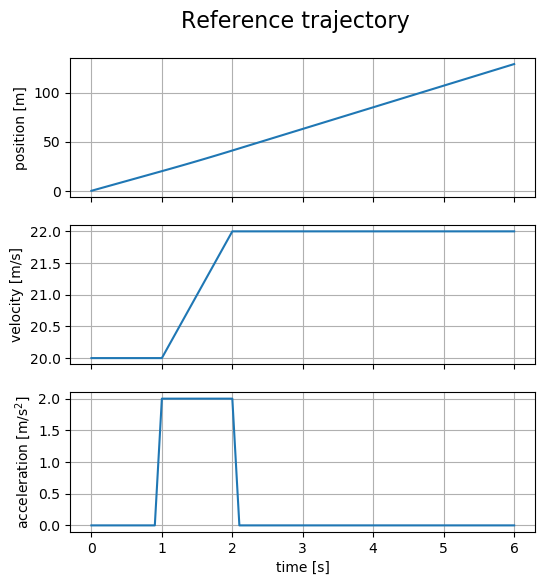

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

### Leader reference tracking

In [7]:
x_track = np.zeros((dyn.n, T-H))
u_track = np.zeros((dyn.m, T-H-1))

# initial condition
x_track[:, 0] = x_ref[:, 0]

# initialized assumed states, controls, and outputs for first timestep
x_a_track = np.zeros((dyn.n, H + 1))
y_a_track = np.zeros((dyn.p, H + 1))
u_a_track = np.zeros((dyn.m, H))
x_a_track[:, 0] = x_track[:, 0]
y_a_track[:, 0] = dyn.sense(x_a_track[:, 0])
for k in range(H):
    x_a_track[:, k+1] = dyn.forward(x_a_track[:, k], u_a_track[:, k])
    y_a_track[:, k+1] = dyn.sense(x_a_track[:, k+1])

In [8]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    x_0 = x_track[:, k]
    y_a = y_a_track
    y_pred_a = y_ref[:, k:k+H+1]
    d = 0.
    u_opt, x_opt, y_opt, value = pfmpc.control(x_0, y_a, y_pred_a, d)
    u_track[:, k] = u_opt[:, 0]
    x_track[:, k+1] = dyn.forward(x_0, u_opt[:, 0])

    # update assumed state, control, output
    u_a_track[:, :H-1] = u_opt[:, 1:H]
    u_a_track[:, H-1] = np.zeros((dyn.m))
    x_a_track[:, 0] = x_opt[:, 1]
    y_a_track[:, 0] = dyn.sense(x_a_track[:, 0])
    for k in range(H):
        x_a_track[:, k+1] = dyn.forward(x_a_track[:, k], u_a_track[:, k])
        y_a_track[:, k+1] = dyn.sense(x_a_track[:, k+1])

end_time = time.time()
avg_time = (end_time - start_time) / (T - H)
print(f"pf mpc leader track avg rate: {1 / avg_time} s")

100%|██████████| 60/60 [00:05<00:00, 11.27it/s]

pf mpc leader track avg rate: 11.451462283707258 s


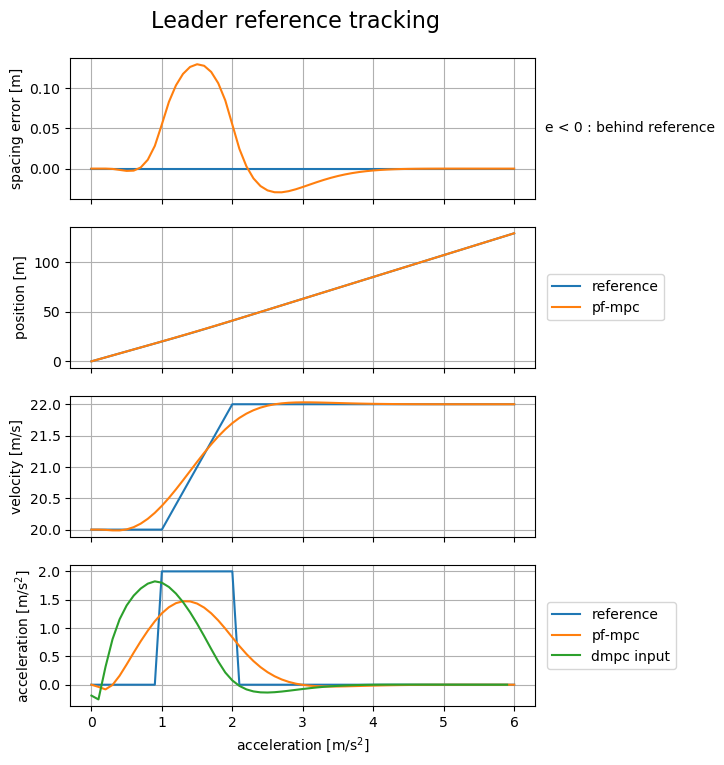

In [9]:
fig, ax = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

ax[0].plot(t_range[:T-H], np.zeros(T-H), label="reference")
ax[0].plot(t_range[:T-H], x_track[0, :T-H] - x_ref[0, :T-H], label="pf-mpc")
ax[0].grid()
ax[0].text(1.02, 0.5, "e < 0 : behind reference", va='center', transform=ax[0].transAxes)
for i in range(1, x_ref.shape[0] + 1):
    ax[i].plot(t_range_mpc, x_ref[i-1, :T-H], label="reference")
    ax[i].grid()

ax[1].plot(t_range_mpc, x_track[0, :], label="pf-mpc")
ax[2].plot(t_range_mpc, x_track[1, :], label="pf-mpc")
ax[3].plot(t_range_mpc, x_track[2, :], label="pf-mpc")
ax[3].plot(t_range_mpc[:-1], u_track[0, :], label="dmpc input")

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("position [m]")
ax[2].set_ylabel("velocity [m/s]")
ax[3].set_xlabel(r"acceleration [m/s$^2$]")
ax[3].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
ax[3].legend(bbox_to_anchor=(1.01, 0.5), loc="center left");

## Predecessor follower platoon analysis

In [10]:
x_pfmpc = [np.zeros((dyn.n, T-H)) for _ in range(N + 1)]
u_pfmpc = [np.zeros((dyn.m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_pfmpc[0] = x_ref[:, :T-H]
u_pfmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_pfmpc[0][1, 0], x_pfmpc[0][2, 0]])

# initialize assumed states, controls, and output for first timestep
x_a_pfmpc = [np.zeros((dyn.n, H + 1)) for _ in range(N + 1)]
x_a_pfmpc[0] = x_pfmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_pfmpc[i][:, 0] = x_pfmpc[i][:, 0]

y_a_pfmpc = [np.zeros((dyn.p, H + 1)) for _ in range(N + 1)]
y_a_pfmpc[0] = x_pfmpc[0][:2, :H+1]
for i in range(1, N + 1):
    y_a_pfmpc[i][:, 0] = dyn.sense(x_a_pfmpc[i][:, 0])

u_a_pfmpc = [np.zeros((dyn.m, H)) for _ in range(N + 1)]
u_a_pfmpc[0] = u_pfmpc[0][:H]

for i in range(1, N+1):
    for k in range(H):
        x_a_pfmpc[i][:, k+1] = dyn.forward(x_a_pfmpc[i][:, k], u_a_pfmpc[i][:, k])
        y_a_pfmpc[i][:, k+1] = dyn.sense(x_a_pfmpc[i][:, k+1])

x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

In [11]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    for i in range(1, N + 1):
        x_0 = x_pfmpc[i][:, k]
        y_a = y_a_pfmpc_prev[i]
        y_pred_a = y_a_pfmpc_prev[i-1]
        d = 0 if i == 1 else d_des
        u_opt, x_opt, y_opt, value = pfmpc.control(x_0, y_a, y_pred_a, d)
        u_pfmpc[i][:, k] = u_opt[:, 0]
        x_pfmpc[i][:, k+1] = dyn.forward(x_0, u_opt[:, 0])

        # update assumed state, control, input
        u_a_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_pfmpc[i][:, H-1] = np.zeros((dyn.m))
        x_a_pfmpc[i][:, 0] = x_opt[:, 1]
        y_a_pfmpc[i][:, 0] = dyn.sense(x_a_pfmpc[i][:, 0])
        for t in range(H):
            x_a_pfmpc[i][:, t+1] = dyn.forward(x_a_pfmpc[i][:, t], u_a_pfmpc[i][:, t])
            y_a_pfmpc[i][:, t+1] = dyn.sense(x_a_pfmpc[i][:, t+1])
    
    x_a_pfmpc[0] = x_ref[:, k+1:k+H+2]
    y_a_pfmpc[0] = x_ref[:2, k+1:k+H+2]
    u_a_pfmpc[0] = x_ref[2, k+1:k+H+1]

    x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
    y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
    u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (N * (T - H))
print(f"\npf-mpc average time: {avg_time} s")

100%|██████████| 60/60 [00:37<00:00,  1.61it/s]


pf-mpc average time: 0.08740657386511774 s


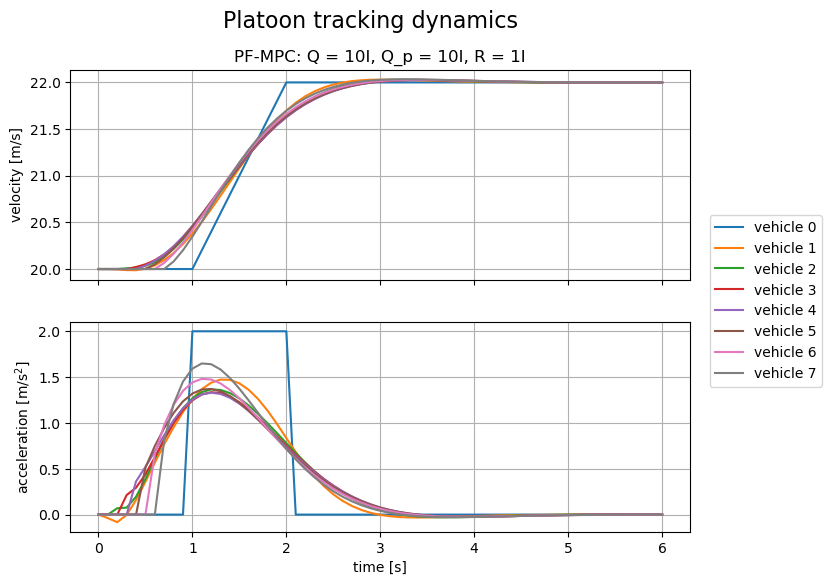

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(f"PF-MPC: Q = {q}I, Q_p = {q_p}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(N + 1):
    # ax[0].plot(t_range_mpc, x_pfmpc[i][0, :], label=f"vehicle {i}")
    ax[0].plot(t_range_mpc, x_pfmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_pfmpc[i][2, :], label=f"vehicle {i}")

# ax[0].set_ylabel("position [m]")
ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
# ax[2].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")

In [13]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[0][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[0][1, :]

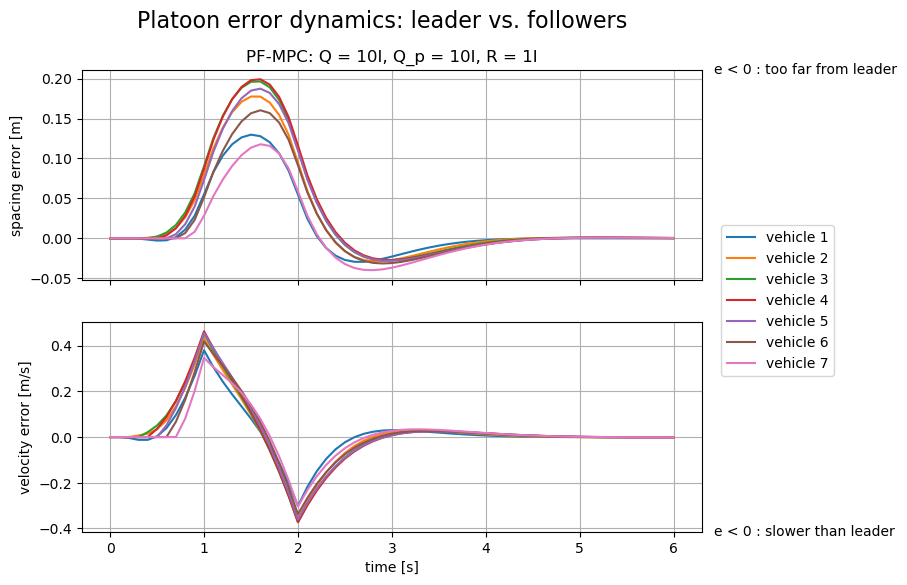

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(f"PF-MPC: Q = {q}I, Q_p = {q_p}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(1, N+1):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")

In [15]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[i-1][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[i-1][1, :]

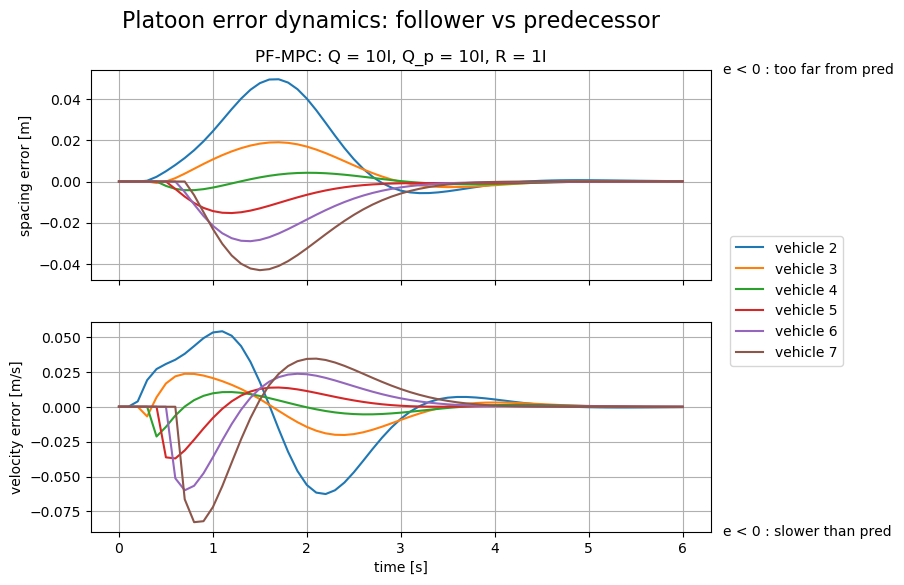

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(f"PF-MPC: Q = {q}I, Q_p = {q_p}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(2, N+1):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")

## Reference trajectory - Deceleration

In [17]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 18.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

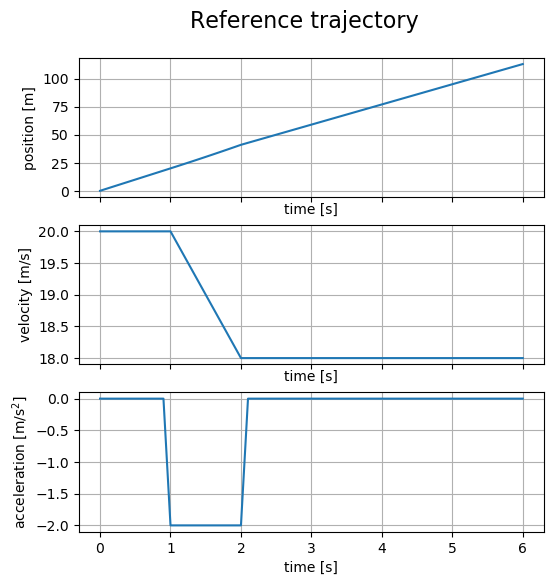

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].set_xlabel("time [s]")
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]");

### Predecessor follower platoon analysis

In [19]:
x_pfmpc = [np.zeros((dyn.n, T-H)) for _ in range(N + 1)]
u_pfmpc = [np.zeros((dyn.m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_pfmpc[0] = x_ref[:, :T-H]
u_pfmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_pfmpc[i][:, 0] = np.array([-(i-1)*d, x_pfmpc[0][1, 0], x_pfmpc[0][2, 0]])

# initialize assumed states, controls, and output for first timestep
x_a_pfmpc = [np.zeros((dyn.n, H + 1)) for _ in range(N + 1)]
x_a_pfmpc[0] = x_pfmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_pfmpc[i][:, 0] = x_pfmpc[i][:, 0]

y_a_pfmpc = [np.zeros((dyn.p, H + 1)) for _ in range(N + 1)]
y_a_pfmpc[0] = x_pfmpc[0][:2, :H+1]
for i in range(1, N + 1):
    y_a_pfmpc[i][:, 0] = dyn.sense(x_a_pfmpc[i][:, 0])

u_a_pfmpc = [np.zeros((dyn.m, H)) for _ in range(N + 1)]
u_a_pfmpc[0] = u_pfmpc[0][:H]

for i in range(1, N+1):
    for k in range(H):
        x_a_pfmpc[i][:, k+1] = dyn.forward(x_a_pfmpc[i][:, k], u_a_pfmpc[i][:, k])
        y_a_pfmpc[i][:, k+1] = dyn.sense(x_a_pfmpc[i][:, k+1])

x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

In [20]:
start_time = time.time()
for k in tqdm(range(T - H - 1)):
    for i in range(1, N + 1):
        x_0 = x_pfmpc[i][:, k]
        y_a = y_a_pfmpc_prev[i]
        y_pred_a = y_a_pfmpc_prev[i-1]
        d = 0 if i == 1 else d_des
        u_opt, x_opt, y_opt, value = pfmpc.control(x_0, y_a, y_pred_a, d)
        u_pfmpc[i][:, k] = u_opt[:, 0]
        x_pfmpc[i][:, k+1] = dyn.forward(x_0, u_opt[:, 0])

        # update assumed state, control, input
        u_a_pfmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_pfmpc[i][:, H-1] = np.zeros((dyn.m))
        x_a_pfmpc[i][:, 0] = x_opt[:, 1]
        y_a_pfmpc[i][:, 0] = dyn.sense(x_a_pfmpc[i][:, 0])
        for t in range(H):
            x_a_pfmpc[i][:, t+1] = dyn.forward(x_a_pfmpc[i][:, t], u_a_pfmpc[i][:, t])
            y_a_pfmpc[i][:, t+1] = dyn.sense(x_a_pfmpc[i][:, t+1])
    
    x_a_pfmpc[0] = x_ref[:, k+1:k+H+2]
    y_a_pfmpc[0] = x_ref[:2, k+1:k+H+2]
    u_a_pfmpc[0] = x_ref[2, k+1:k+H+1]

    x_a_pfmpc_prev = copy.deepcopy(x_a_pfmpc)
    y_a_pfmpc_prev = copy.deepcopy(y_a_pfmpc)
    u_a_pfmpc_prev = copy.deepcopy(u_a_pfmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (N * (T - H))
print(f"\npf-mpc average time: {avg_time} s")

  0%|          | 0/60 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

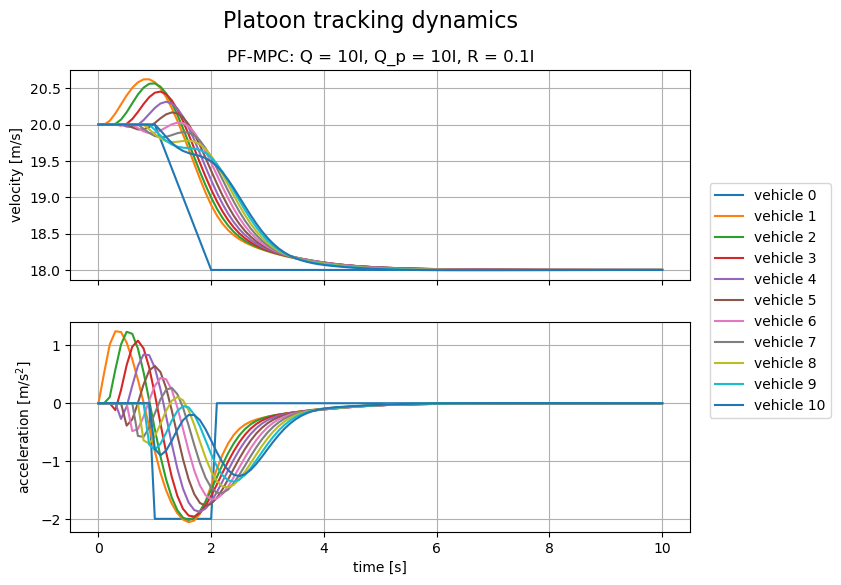

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(f"PF-MPC: Q = {q}I, Q_p = {q_p}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(N + 1):
    # ax[0].plot(t_range_mpc, x_pfmpc[i][0, :], label=f"vehicle {i}")
    ax[0].plot(t_range_mpc, x_pfmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_pfmpc[i][2, :], label=f"vehicle {i}")

# ax[0].set_ylabel("position [m]")
ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
# ax[2].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")

In [ ]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[0][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[0][1, :]

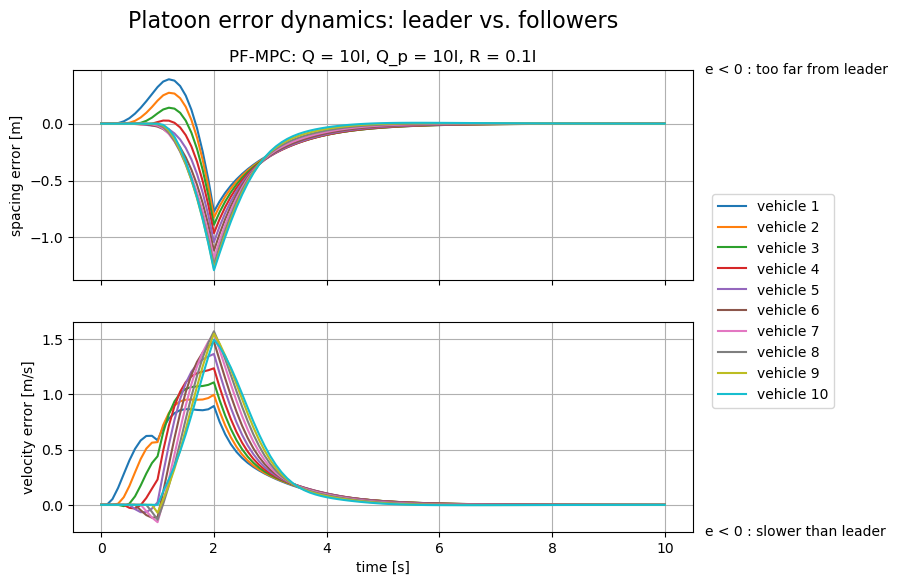

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(f"PF-MPC: Q = {q}I, Q_p = {q_p}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(1, N+1):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")

In [ ]:
d_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_pfmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_pfmpc[i] = x_pfmpc[i][0, :] - x_pfmpc[i-1][0, :] + d
    v_error_pfmpc[i] = x_pfmpc[i][1, :] - x_pfmpc[i-1][1, :]

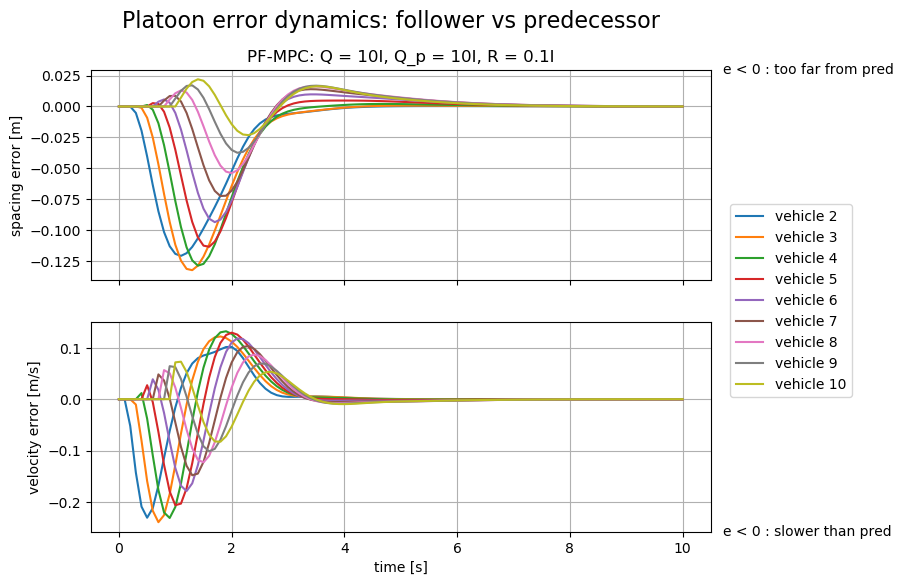

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(f"PF-MPC: Q = {q}I, Q_p = {q_p}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(2, N+1):
    ax[0].plot(t_range[:T-H], d_error_pfmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_pfmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")